<a href="https://colab.research.google.com/github/angulartist/Deep-Learning-AnyPercent/blob/master/kaggle/mnist/kannada_mnist_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.test.gpu_device_name())

import os
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')     
%matplotlib inline

import pandas as pd

import numpy as np
import cv2
from google.colab import drive

/device:GPU:0


# Setup

In [203]:
# base_dir = '../input/Kannada-MNIST/'

# (Google Colab) - Authorize R/W access to the Drive.

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'deepl/kannada_mnist/'

base_dir

Mounted at /content/gdrive


'/content/gdrive/My Drive/deepl/kannada_mnist/'

In [0]:
L = 10 # labels
S = 28 # dimensions (H, W)
C = 1  # depth

# Load dataset

In [0]:
# Load the Kannada MNIST training dataset downloaded from Kaggle
# into a Pandas DataFrame
X_df = pd.read_csv(os.path.join(base_dir, 'train.csv.zip'))

In [206]:
# Plot pixel intensities
X_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Extract dataset samples pixel intensities
X = X_df.iloc[:, 1:]
X = X.values 

# Extract labels
y = X_df.iloc[:, 0]
y = y.values

# Plot labels
pd.DataFrame(y)

del X_df

In [208]:
# Reshape dataset samples to (num_samples, height[rows], width[cols])
# to do some plotting
X = X.reshape(X.shape[0], S, S)
X.shape

(60000, 28, 28)

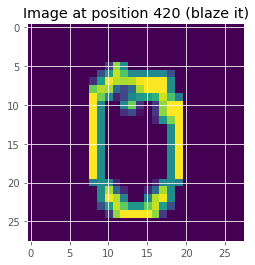

In [209]:
# Plot a sample of the dataset
plt.imshow(X[420])
plt.title(label='Image at position 420 (blaze it)')
plt.show()

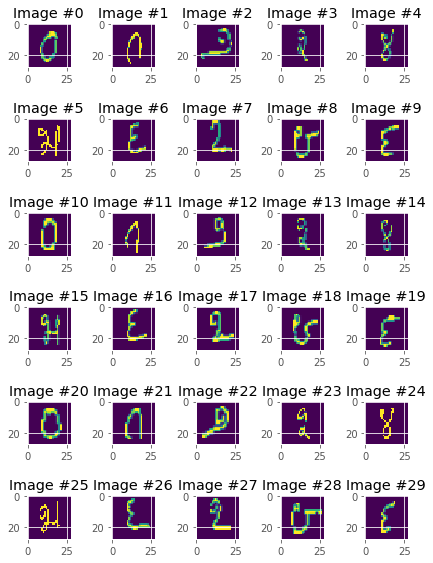

In [210]:
# Plot more samples

fig, ax = plt.subplots(
    nrows=6,
    ncols=5,
    figsize=[6, 8]
)

for index, axi in enumerate(ax.flat):
    axi.imshow(X[index])
    axi.set_title(f'Image #{index}')

plt.tight_layout(True)
plt.show()

In [0]:
# Normalize pixel intensities to range [0, 1]
X = X.astype('float32') / 255.0

In [212]:
# Reshape the samples from the dataset
# to meet Keras requirements (num_samples, height, width, num_channels)
X = X.reshape(-1, 28, 28, 1)
X.shape

(60000, 28, 28, 1)

In [213]:
# One-hot encode labels from integers to vectors
y = to_categorical(y, num_classes=L)
pd.DataFrame(y)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [214]:
# Split the dataset into 80/20 train/test sets
(X_train, X_ttest, y_train, y_ttest) = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape) # <- num of train samples
print(X_ttest.shape) # <- num of test  samples

del X

(48000, 28, 28, 1)
(12000, 28, 28, 1)


In [0]:
# Data Augmentation: Set the image generator

daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=12,
    zoom_range = 0.25, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)

# Build the model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU

class CustomNet(object):
    @staticmethod
    def build(width, height, num_classes, depth=3):
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1
        
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        
        # (Conv => LReLU => BN) * 3 => DO
        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Dropout(0.2))
        
        # (FC => LReLU => BN) * 2 => DO
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Softmax
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        
        print(model.summary())
        
        return model

In [217]:
net = CustomNet()

model = net.build(
    width=S,
    height=S,
    num_classes=L,
    depth=C)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_128 (LeakyReLU)  (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_129 (LeakyReLU)  (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 28, 28, 32)      

# Set the optimizer and hyperparameters

In [0]:
num_epochs = 50

In [0]:
init_lr = 0.01

adam_opt = Adam(
    lr=init_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=0.0
)

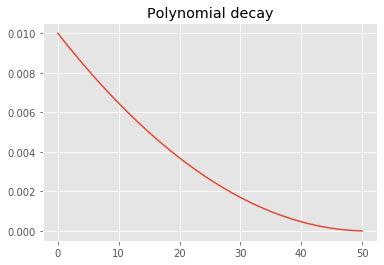

In [220]:
# Polynomial decay
def polynomial_decay(epoch):
    max_epochs = num_epochs
    power = 2.0
    
    return init_lr * (1 - (epoch / float(max_epochs))) ** power

x = np.linspace(0, num_epochs)
fx = [init_lr * (1 - (i / float(num_epochs))) ** 2.0 for i in range(len(x))]
plt.plot(x, fx)
plt.title(label=f'Polynomial decay')
plt.show()

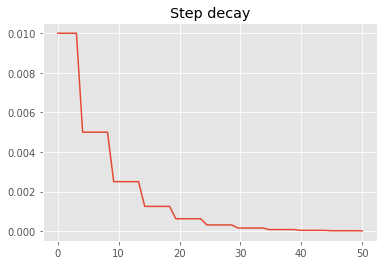

In [221]:
# Step decay
def step_decay(epoch):
  factor    = 0.5
  drop_rate = 5

  return float(init_lr * (factor ** np.floor((1 + epoch) / drop_rate)))

x = np.linspace(0, num_epochs)
fx = [float(init_lr * (0.5 ** np.floor((1 + i) / 5))) for i in range(len(x))]
plt.plot(x, fx)
plt.title(label=f'Step decay')
plt.show()

# Training time!

In [0]:
# Ignore checkpointing on Kaggle kernel

'''
checkpointHandler = ModelCheckpoint(
    os.path.join(base_dir, 'best_weights.hdf5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
'''

callbacks = [
    LearningRateScheduler(step_decay),
    # LearningRateScheduler(polynomial_decay),
    # checkpointHandler
]

In [224]:
batch_size = 128

print('# Compiling the model...')
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam_opt,
    metrics=['accuracy']
)

print('# Training the network...')
h = model.fit_generator(
    daug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_ttest, y_ttest),
    epochs=num_epochs,
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=callbacks,
    verbose=1
)

# Compiling the model...
# Training the network...
Epoch 1/50
375/375 [==============================] - 36s 97ms/step - loss: 0.1319 - acc: 0.9609 - val_loss: 0.0963 - val_acc: 0.9738
Epoch 2/50
375/375 [==============================] - 30s 81ms/step - loss: 0.0794 - acc: 0.9769 - val_loss: 3.8275 - val_acc: 0.4957
Epoch 3/50
375/375 [==============================] - 30s 81ms/step - loss: 0.0649 - acc: 0.9817 - val_loss: 16.8661 - val_acc: 0.2232
Epoch 4/50
375/375 [==============================] - 30s 79ms/step - loss: 0.0618 - acc: 0.9823 - val_loss: 0.1118 - val_acc: 0.9700
Epoch 5/50
375/375 [==============================] - 29s 78ms/step - loss: 0.0384 - acc: 0.9897 - val_loss: 0.0151 - val_acc: 0.9960
Epoch 6/50
375/375 [==============================] - 29s 77ms/step - loss: 0.0364 - acc: 0.9891 - val_loss: 0.0345 - val_acc: 0.9891
Epoch 7/50
375/375 [==============================] - 29s 78ms/step - loss: 0.0405 - acc: 0.9887 - val_loss: 0.0692 - val_acc: 0.9778
Epoch 8/50

# Evaluate

In [225]:
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

print('Confusion matrix:')
preds = model.predict(X_ttest, batch_size=batch_size)
print(classification_report(y_ttest.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

Confusion matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1177
           1       1.00      1.00      1.00      1218
           2       1.00      1.00      1.00      1224
           3       1.00      1.00      1.00      1184
           4       1.00      1.00      1.00      1221
           5       1.00      1.00      1.00      1188
           6       0.99      1.00      1.00      1169
           7       1.00      1.00      1.00      1219
           8       1.00      1.00      1.00      1186
           9       1.00      0.99      1.00      1214

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



# Visualize curves

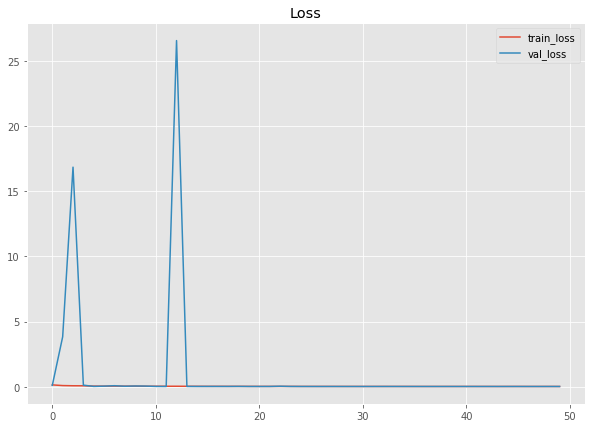

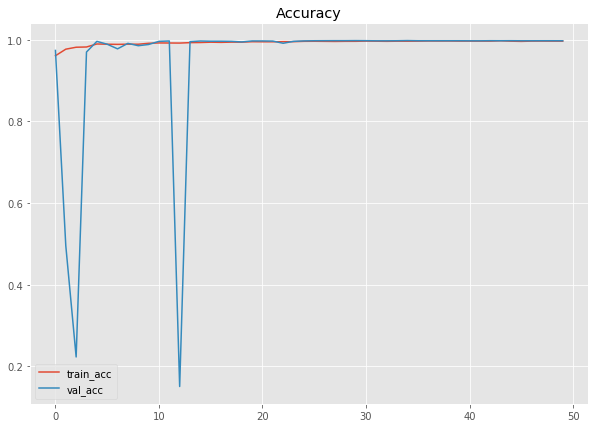

In [226]:
# Loss
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_acc')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# Kaggle

In [227]:
'''
Pushing a submission to Kaggle.

First of, load the test set, normalize it and reshape it.
Then, make predictions via the trained model and build the
submission csv file.
'''

sub_X_test = pd.read_csv(os.path.join(base_dir, 'test.csv.zip')) # Load CSV
sub_X_test = sub_X_test.drop('id', axis=1)                       # Drop the ID column
sub_X_test = sub_X_test.iloc[:,:].values                         # Get raw pixel intensities
sub_X_test = sub_X_test.reshape(sub_X_test.shape[0], S, S, C)    # Reshape to meet Keras requirements
sub_X_test = sub_X_test / 255.0                                  # Normalize to range [0, 1]

preds = model.predict_classes(sub_X_test, batch_size=batch_size) # Make predictions and build the submission file

# https://www.kaggle.com/c/Kannada-MNIST/discussion/110586
id_col = np.arange(preds.shape[0])
submission = pd.DataFrame({'id': id_col, 'label': preds})
print(pd.DataFrame(submission))
submission.to_csv(os.path.join(base_dir, 'submission.csv'), index = False)

        id  label
0        0      3
1        1      0
2        2      2
3        3      6
4        4      7
...    ...    ...
4995  4995      1
4996  4996      0
4997  4997      1
4998  4998      6
4999  4999      3

[5000 rows x 2 columns]
